In [1]:
import os
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Extraire DIC data

In [2]:
filename = "CT_R35_1"
# load csv file XY positions
x_coord = pd.read_csv('/Users/xinyuanzhai/Desktop/Donnes_DIC/' +  filename +   '/x.csv',names=["X"])
y_coord = pd.read_csv('/Users/xinyuanzhai/Desktop/Donnes_DIC/' +  filename +   '/y.csv',names=["Y"])
ux = pd.read_csv('/Users/xinyuanzhai/Desktop/Donnes_DIC/' +  filename +   '/u1_cod.csv',header=None)
uy = pd.read_csv('/Users/xinyuanzhai/Desktop/Donnes_DIC/' +  filename +   '/u2_cod.csv',header=None)

#create dataframe for DIC data
contour = pd.concat([x_coord, y_coord,ux,uy],axis=1)

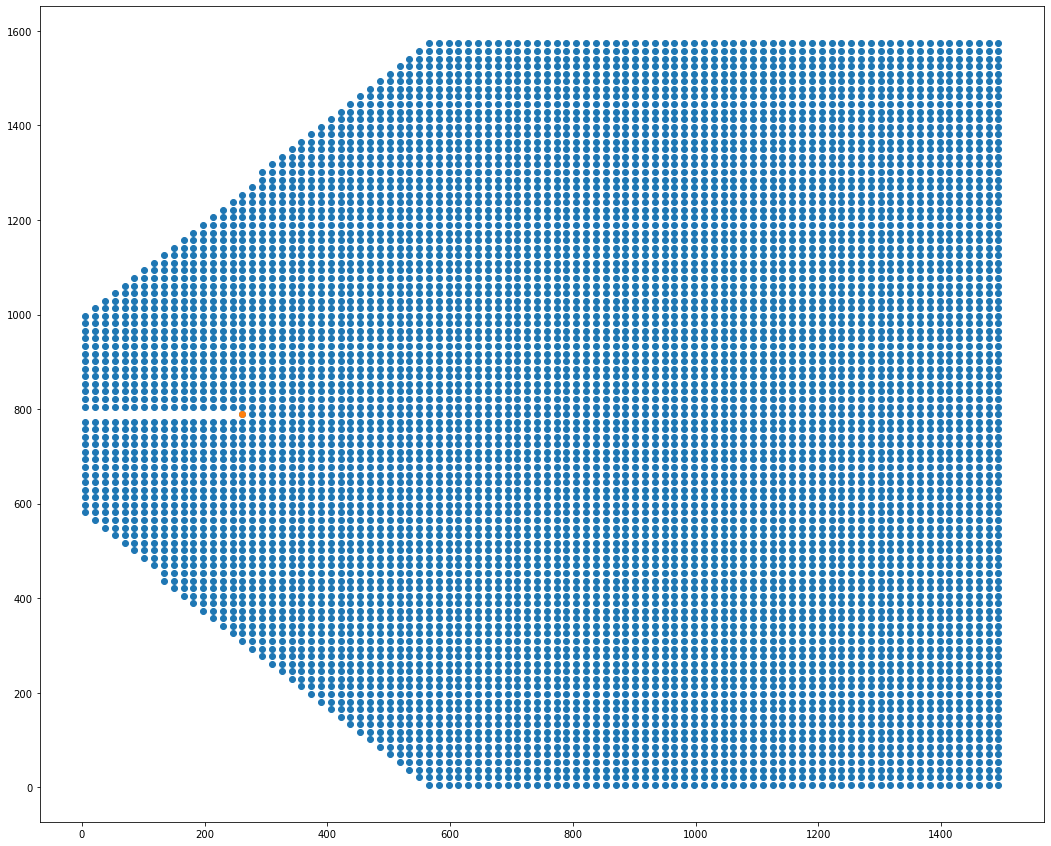

In [3]:
#plot of DIC data
x_ = contour['X']
y_ = contour['Y']
plt.figure(figsize=(18, 15))
plt.scatter(x_,y_)

xtip = 261.5
ytip = 789.5
plt.scatter(xtip,ytip)

In [4]:
#3rd contour to choose
ymax=contour['Y'].max()
ymin=contour['Y'].min()
xmax=contour['X'].max()
xmin=contour['X'].min()
print("Xmin {0} Xmax {1} Ymin {2} Ymax {3}".format(xmin, xmax, ymin, ymax))

Xmin 5.5 Xmax 1493.5 Ymin 5.5 Ymax 1573.5


In [5]:
y_mid  = ytip
pixel = 16
nc = 1
#given 2nd contour
x_n_min = xmin+nc*pixel
#x_n_max = xmax-nc*pixel
#y_n_min = ymin+(nc)*pixel
#y_n_max = ymax-(nc)*pixel

In [10]:
#contour left
left1 = contour[(contour.X==x_n_min) & (contour.Y < y_mid)]
left1_min = left1['Y'].min()
left1.sort_values(by=['Y'],ascending=False,inplace=True)


left2 = contour[(contour.X==x_n_min) & (contour.Y > y_mid)]
left2_max = left2['Y'].max()
left2.sort_values(by=['Y'],ascending=False,inplace=True)



y_left_min = left1['Y'].min()
y_left_max = left2['Y'].max()


565.5
1013.5


In [27]:
bias_top=pd.DataFrame()
for i in range(1,100):
    bias_top = bias_top.append(contour[(contour.X==x_n_min + i*pixel) & (contour.Y==y_left_max + i*pixel)])

bias_top.sort_values(by=['X'],ascending=False,inplace=True)

bias_bottom=pd.DataFrame()
for i in range(1,100):
    bias_bottom = bias_bottom.append(contour[(contour.X==x_n_min + i*pixel) & (contour.Y==y_left_min -i*pixel)])
    
bias_bottom.sort_values(by=['X'],ascending=True,inplace=True)

#get the point max of bias
x_bias_max = bias_top['X'].max()
y_bias_max = bias_top['Y'].max()
y_bias_min = bias_bottom['Y'].min()

In [17]:
top = contour[(contour.Y==y_bias_max) & (contour.X > x_bias_max)]
top.sort_values(by=['X'],ascending=False,inplace=True)

bottom = contour[(contour.Y==y_bias_min) & (contour. X> x_bias_max)]
bottom.sort_values(by=['X'],ascending=True,inplace=True)

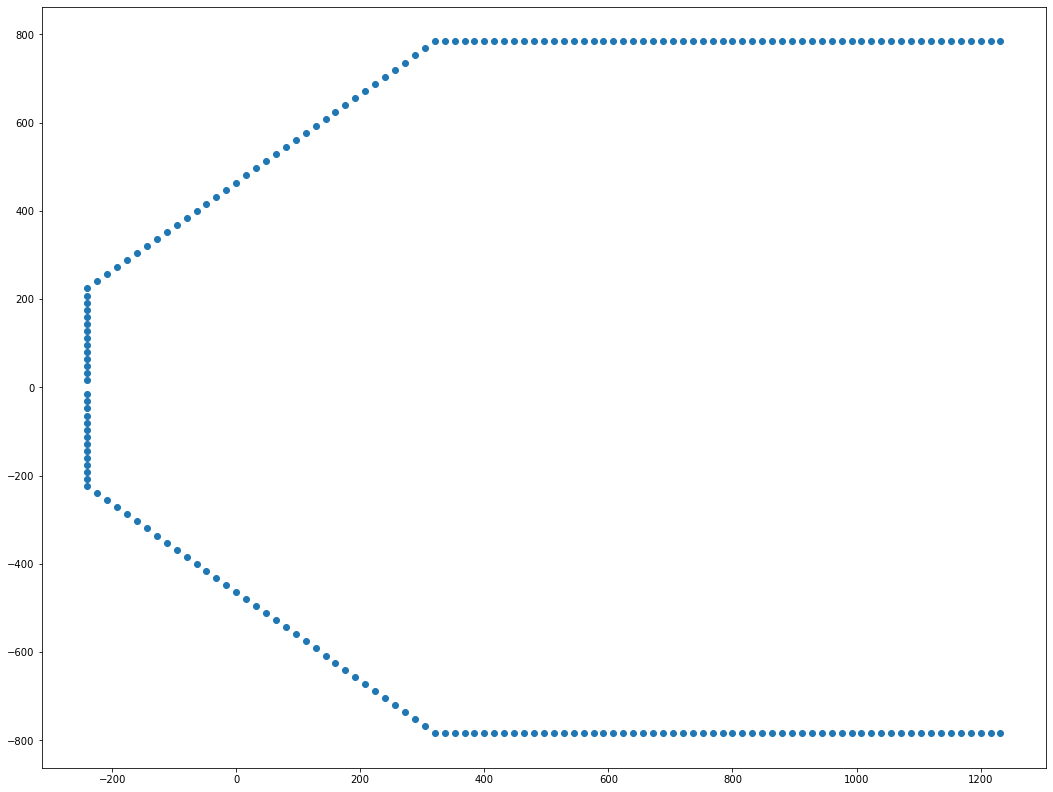

In [30]:
#drop in to new dataframe
final = pd.concat([left1,bias_bottom,bottom,top,bias_top,left2],axis=0)

#put crack tip to (0,0)

final["X"] = final["X"] - xtip
final["Y"] = final["Y"] - ytip

#
x_final = final['X']
y_final = final['Y']
plt.figure(figsize=(18, 14))
plt.scatter(x_final,y_final)

In [49]:
#save to csv
final.to_csv('xy_position_libre.csv',columns= ['X', 'Y'],index = False)
charge = final.drop(columns=['X', 'Y'])
charge.to_csv('charge_libre.csv',index = False)

# Build Gmsh file 

In [50]:
L = 50.
scale=2e-5

# load csv file XY positions
filename = "xy_position_libre"
DIC_0 = pd.read_csv('/Users/xinyuanzhai/DIC_gradam/CT_35_1/' +  filename +   '.csv')

#convert to mm and then dimensionless with L = 50
DIC_0 = DIC_0*1000*scale/L

In [51]:
filename1 = "charge_libre"
U_xy = pd.read_csv('/Users/xinyuanzhai/DIC_gradam/CT_35_1/' +  filename1 +   '.csv')

#convert to mm then dimensionless with L = 50
U_xy = U_xy*1000*scale/L
U_xy.columns = np.arange(len(U_xy.columns))

In [52]:
#Get the value of 
xval1 = DIC_0.loc[0,'X']


#Replace the value x and y in geo file
with open('mesh/DIC.geo', 'r') as file :
    filedata = file.read()

filedata = filedata.replace('xval = ', 'xval = '+ str(xval1))

# Write the file out again
with open('mesh/DIC_running.geo', 'w') as file:
    file.write(filedata)

In [53]:
#get mid point
#mid_p = DIC_0[(DIC_0.X==DIC_0['X'].max()) & (DIC_0.Y==DIC_0['Y'].min())]
#mid_value = mid_p.index.values[0]

#Extract x y cood and the displacement
xcord = DIC_0.X
ycord = DIC_0.Y

#Put the geo language in a list
data = []

j = 5 #Nombre de point dans geofile
k = 4 #Nombre de line dans geofile 




for i in range(len(xcord)):
    data.append("//+")
    data.append("Point(" + str(i+j+1) + ") = {" + str(xcord[i]) + ", " + str(ycord[i]) + ", 0, f0};")

data.append("//+")
data.append("Line(" + str(k+1) + ") = {" +str(2) + ", " + str(j+1) + "};")  
    
for i in range(len(xcord)-1):
    data.append("//+")
    data.append("Line(" + str(i+k+2) + ") = {" + str(i+j+1)+ ", " + str(i+j+2) + "};")

#two line
data.append("//+")
data.append("Line(" + str(len(xcord)+k+1) + ") = {" + str(len(xcord)+j)+ ", " + str(1) + "};")


    
# Write the point cood and line data in new geofile call DIC_1.geo
geofile = open("mesh/DIC_running.geo","a")

for line in data:
    
    geofile.write(line+'\n')
    
geofile.close()


In [54]:
# pls check this mid_line
mid_value = math.ceil(((len(xcord))/2)+k)+1
mid_value

111

In [55]:
last = str(len(xcord)+k+1)

curve= ""
#Curve loop for lower side mesh
for i in range(len(xcord)+k):
    loop_value = i+1
    curve += str(loop_value) + ',' 

curve += last

In [56]:
contour0 = ""
#Curve loop for upper side mesh
for i in range(mid_value-k):
    loop_value = i+mid_value+1
    contour0 += str(loop_value) + ',' 

contour0 += last

In [57]:
first = str(mid_value-1)
contour1 = ""
#Curve loop for upper side mesh
for i in range(mid_value-k-2):
    loop_value = i+1+k
    contour1 += str(loop_value) + ',' 

contour1 += first

In [58]:
geofile = open("mesh/DIC_running.geo","a")

#write in geofile for lower side:
geofile.write("//+" +'\n')
geofile.write("Curve loop(" + str(1) + ") = {" + curve + "};" +'\n')
geofile.write("//+" +'\n')
geofile.write("Plane Surface(" + str(1) + ")= {" + str(1) + "};" +'\n')


#Physique surface : usually we have 1 surfaces
geofile.write("//+" +'\n')
geofile.write('Physical Surface("1") = {1};'+'\n')

#create physic curve for upper side :

geofile.write("//+" +'\n')
geofile.write('Physical Curve("2") = {' + contour0 + '};' +'\n')

geofile.write("//+" +'\n')
geofile.write('Physical Curve("3") = {' + contour1 + '};' +'\n')

geofile.write("//+" +'\n')
geofile.write('Physical Curve("4") = {' + str(mid_value) + '};' +'\n')

geofile.close()

# Convert mesh

In [59]:
os.system("python3 export_msh.py")

0

# plot direction